# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

## TODO:
* Find popular methods to do segmentation on the brain MRI images from the literature
* Check description of the two-threshold method, that was successful
* Try different contour methods (tune the parameters)
* Fix the gaussian-fitting method (the gaussian not fitting the histogram)
* Try to do prefiltering before brain segmentation (apply before all methods)

In the region growing we add two-threshold method, in the contour detection we add canny/sobel/etc methods, plus we add active contour method (still TODO). In additional methods we add GaussianMixture. 

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

In [2]:
import skimage.io
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import closing, square, binary_erosion, binary_dilation, binary_opening, binary_closing, disk
from sklearn.cluster import DBSCAN, KMeans
from skimage.filters import median, gaussian
from skimage.segmentation import active_contour
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 Brain image visualization

Let us first visualize the brain and try to get an idea how to solve the problem.

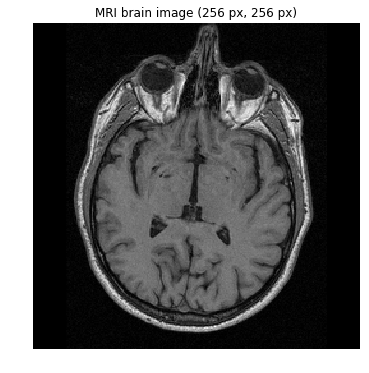

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape
num_pixel = im_h*im_w

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

We can see that the objects on the image have more intensity than the background. To understand how gray levels are distributed over pixels, let us plot a histogram.

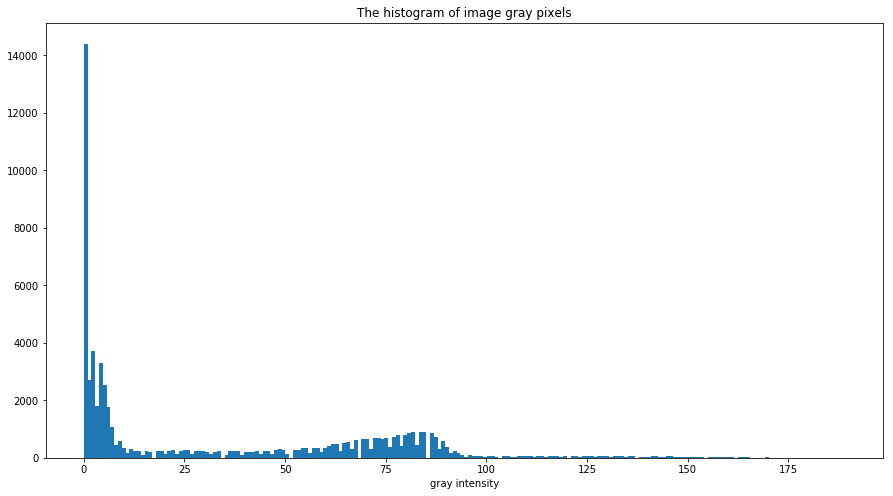

In [4]:
nbins = 200

fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(brain_im.ravel(), bins=nbins)
ax.set_xlabel('gray intensity')
ax.set_title('The histogram of image gray pixels');

As you may see, we have a bimodal distribution and the two peaks correspond either to background (the peak near zero) or to the brain contours (around 75-80). In addition, we observe that we have noise which lead to the *skewness* of the peaks.

Using this information we can try different *region growing* methods to identify and label the objects which have the gray intensity higher than specific threshold. Moreover, to compute the size of the brain, we can use the fact that it is the biggest gray object.

Apart from that we will use *contour detection* methods to identify the edges of the objects.

### 1.2 Region growing

First, let's implement the region growing method to label the identified objects.

In [5]:
def get_neighbours(pixel):
    
    """
        Return 4 neighbours of the input pixel.
    """ 
    
    return [(pixel[0] + 1, pixel[1]), 
            (pixel[0] - 1, pixel[1]),
            (pixel[0], pixel[1] + 1),
            (pixel[0], pixel[1] - 1)]

def grow(pixel_to_start, mask, visited):
    
    """
        Return region starting from pixel_to_start. The region should correspond to mask.
    """
    
    stack = [pixel_to_start]
    region = [pixel_to_start]
    visited[pixel_to_start] = 1

    while len(stack):
        
        # Pick a pixel
        cur_pixel = stack.pop()

        pixels_to_check = get_neighbours(cur_pixel)
        
        # Check if neighbours are not visited and correspond to mask
        pixels_from_region = [pixel for pixel in pixels_to_check if mask[pixel] and not visited[pixel]]
        
        # Update containers
        stack.extend(pixels_from_region)
        for pixel in pixels_from_region:
            visited[pixel] = 1
        region.extend(pixels_from_region)
        
    return region
        
def region_growing(mask):
    
    """
        Region growing method that finds the connected objects in the image indicated by mask and labels them.
    """
    
    regions = []
    visited = np.zeros(mask.shape)
    
    while True: # Each iteration is aimed to process one region
        # Search pixels not attached for any processed region
        pixels_to_grow = mask * (1 - visited)
        
        # If all pixels from the mask are labeled, algorithm identified all objects
        if len(pixels_to_grow[pixels_to_grow > 0]) == 0:
            break
            
        X, Y = np.where(pixels_to_grow > 0)
        pixel_to_start = (X[0], Y[0]) # Pixel from unknown region
        
        region = grow(pixel_to_start, mask, visited)
        regions.append(region)
         
    return regions

I, Oganes, suggest to delete next cells (commented ones) because they are not longer actual.

In [6]:
# Let us first try manually different thresholds if they separate the objects from the background.

In [7]:
# thresholds = np.linspace(20, 75, 12)

# fig, ax = plt.subplots(3, 4, figsize=(20, 12))

# for i, a in enumerate(ax.flatten()):
#     brain_binary = brain_im > thresholds[i]
#     a.imshow(brain_binary, cmap='gray')
#     a.set_title('Binary brain image for threshold {} ({} px, {} px)'.format(thresholds[i], im_h, im_w))
#     a.axis('off')
    
# plt.tight_layout()

In [8]:
# We can observe that the best threshold for the segmentation of the brain is around 60.

In [9]:
# As we can see, this manual threshold probably is not the best after all.. Let us check optimal thresholds, that are implemented in skimage.

In [10]:
# from skimage.filters import try_all_threshold

# fig, ax = try_all_threshold(brain_im, figsize=(10, 15), verbose=False)
# plt.tight_layout()

In [11]:
# Some of them do the work much better!

Looking at the original image we can see that there are roughly three different colors: one corresponds to background, second one mostly to the brain and last one to the skull. In current task we are interested in brain, which has brighter pixels than bakground and darker compared to the skull. Thus we can use double thresholding to extract interested pixels. 

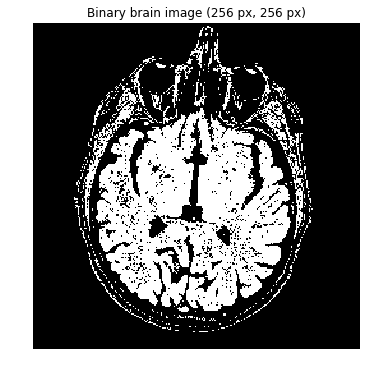

In [12]:
upper_threshold = 90
lower_threshold = 60

brain_im_binary_double = [[(pixel > lower_threshold) and (pixel < upper_threshold) 
                             for pixel in line] for line in brain_im] 

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im_binary_double, cmap='gray')
ax.set_title('Binary brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off');

Now we can apply region growing method to get all regions and then take the biggest one. It will be brain.

In [13]:
regions = region_growing(np.array(brain_im_binary_double))
print(f"{len(regions)} shapes were found")

brain_region = max(regions, key=len)

brain_mask_double_threshold = np.full(brain_im.shape, fill_value=False)
for coords in brain_region:
    brain_mask_double_threshold[coords] = True

652 shapes were found


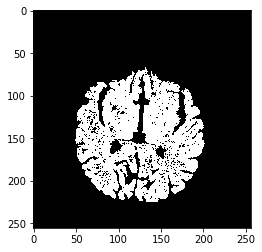

In [14]:
plt.imshow(brain_mask_double_threshold, cmap="gray")
plt.show()

Let's also tru some methods to improve obtained mask by filling holes.

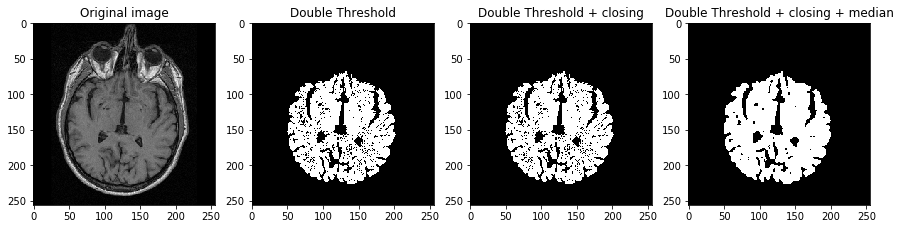

In [15]:
brain_mask_double_threshold_closing = binary_closing(brain_mask_double_threshold, square(1))
brain_mask_double_threshold_closing_median = median(brain_mask_double_threshold_closing, selem=disk(2))

titles = ["Original image", "Double Threshold", "Double Threshold + closing", "Double Threshold + closing + median"]
masks = [brain_im, 
         brain_mask_double_threshold,
         brain_mask_double_threshold_closing,
         brain_mask_double_threshold_closing_median]

fig, ax = plt.subplots(1, len(masks), figsize=(15, 10))

for i in range(len(masks)):
    ax[i].imshow(masks[i], cmap='gray')
    ax[i].set_title(titles[i])

As we can see combination of methods: Double Threshold + closing + median - worked quite good.

### 1.3 Contour detection

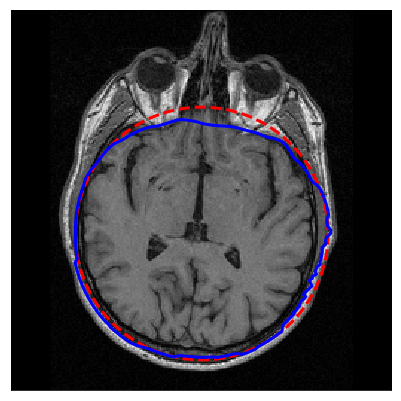

In [16]:
s = np.linspace(0, 2*np.pi, 400)
r = 150 + 85*np.sin(s)
c = 128 + 85*np.cos(s)
init = np.array([r, c]).T

snake = active_contour(median(brain_im, disk(2)),
                       init,
                       alpha=0.5, # Snake length shape parameter. Higher values makes snake contract faster. 
                       beta=0, # Snake smoothness shape parameter. Higher values makes snake smoother 
                       gamma=0.001, # Explicit time stepping parameter.
                       coordinates='rc')

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(brain_im, cmap='gray')
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])

plt.show()

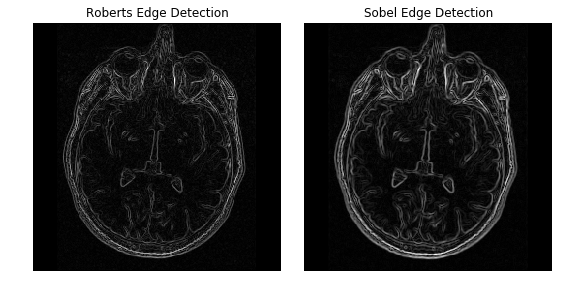

In [17]:
edge_roberts = skimage.filters.roberts(brain_im)
edge_sobel = skimage.filters.sobel(brain_im)

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True,
                         figsize=(8, 4))

axes[0].imshow(edge_roberts, cmap=plt.cm.gray)
axes[0].set_title('Roberts Edge Detection')

axes[1].imshow(edge_sobel, cmap=plt.cm.gray)
axes[1].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

### 1.4 Additional method(s)

#### 1.4.1 GaussianMixture model

Let us use the model, proposed by professor. We will use GaussianMixture model (implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)) to fit Gaussians to the multimodal distribution to perform segmentation. For now, we assume that there are 3 different distributions.

C:\Users\Oganes\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


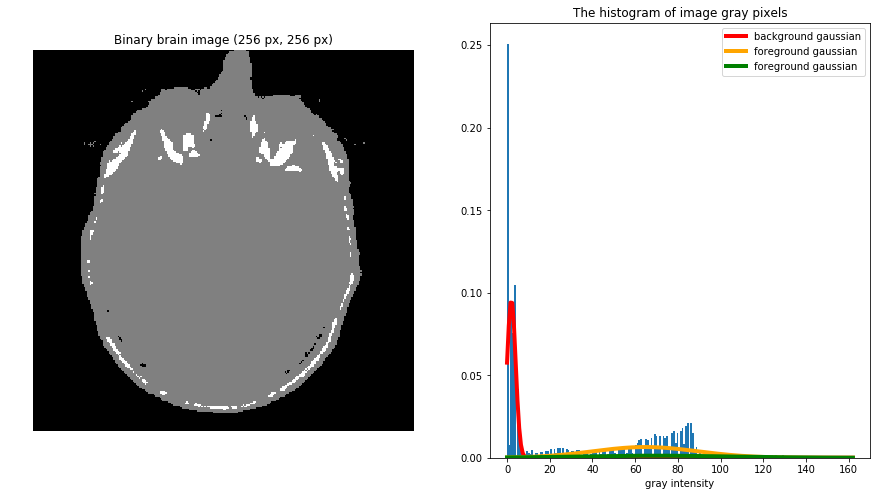

In [18]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.optimize import brentq

def find_optimal_threshold(gauss_1, gauss_2, mu):
    """
        Find the intensity level of the optimal threshold as the intersection
        between two gaussians. 
    """
    return brentq(lambda x: gauss_1(x) - gauss_2(x), min(mu), max(mu))

brain_im_median = median(brain_im, selem=disk(2))

gaus_mix_segm = GaussianMixture(n_components=3, random_state=42, means_init=np.array([0, 70, 80]).reshape(3, 1))
brain_im_binary = gaus_mix_segm.fit_predict(brain_im_median.reshape(num_pixel, 1)).reshape(im_h, im_w)

weights = gaus_mix_segm.weights_.flatten()
mu = gaus_mix_segm.means_.flatten()
sigma = np.sqrt(gaus_mix_segm.covariances_.flatten())


fig, ax = plt.subplots(1, 2, figsize=(15, 8))

ax[0].imshow(brain_im_binary, cmap='gray')
ax[0].set_title('Binary brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')

ax[1].hist(brain_im_median.ravel(), bins=nbins, normed=True)
ax[1].set_xlabel('gray intensity')
ax[1].set_title('The histogram of image gray pixels')

gauss_1 = lambda x: norm.pdf(x, loc=mu[0], scale=sigma[0])
gauss_2 = lambda x: norm.pdf(x, loc=mu[1], scale=sigma[1])
gauss_3 = lambda x: norm.pdf(x, loc=mu[2], scale=sigma[2])

grid_x = np.linspace(brain_im_median.reshape(num_pixel, 1).min(), 
                     brain_im_median.reshape(num_pixel, 1).max(), 
                     200)
gaussian_1 = weights[0]*gauss_1(grid_x)
gaussian_2 = weights[1]*gauss_2(grid_x)
gaussian_3 = weights[2]*gauss_3(grid_x)

ax[1].plot(grid_x, gaussian_1, lw=4, color='red', label='background gaussian')
ax[1].plot(grid_x, gaussian_2, lw=4, color='orange', label='foreground gaussian')
ax[1].plot(grid_x, gaussian_3, lw=4, color='green', label='foreground gaussian')
ax[1].legend()
plt.show()

In [19]:
v, counts = np.unique(brain_im_binary[0], return_counts=True)
counts

array([248,   8], dtype=int64)

In [20]:
v

array([0, 1], dtype=int64)

In [21]:
mask_gaussian = brain_im_binary == 2

regions = region_growing(mask_gaussian)
print(f"{len(regions)} shapes were found")

brain_region_coords = max(regions, key=len)

brain_mask_gaussian = np.full(brain_im.shape, fill_value=False)
for coords in brain_region_coords:
    brain_mask_gaussian[coords] = True

62 shapes were found


#### 1.4.2 Clustering

Another way to segment image is use clusterisation techniques. Let's try to use combination of pixel's (x, y) coordinates and pixel's value as feature. Thus we will obtain feature matrix of size (256*256, 3) 

In [22]:
feature_matrix_v = np.array([[brain_im[i, k]] for i in range(brain_im.shape[1]) for k in range(brain_im.shape[0])])
feature_matrix_xyv = np.array([[i, k, brain_im[i, k]] for i in range(brain_im.shape[1]) for k in range(brain_im.shape[0])])

In [23]:
clustering_method_names = ["K-means (v) 2 clusters", 
                           "K-means (v) 3 clusters", 
                           "K-means (v) 4 clusters",
                           "K-means (v) 5 clusters"]

In [24]:
clustering = [KMeans(n_clusters=2, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=3, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=4, random_state=42).fit(feature_matrix_v),
              KMeans(n_clusters=5, random_state=42).fit(feature_matrix_v)]

In [25]:
brain_im_clustered = [clustered.labels_.reshape(im_h, im_w) for clustered in clustering]

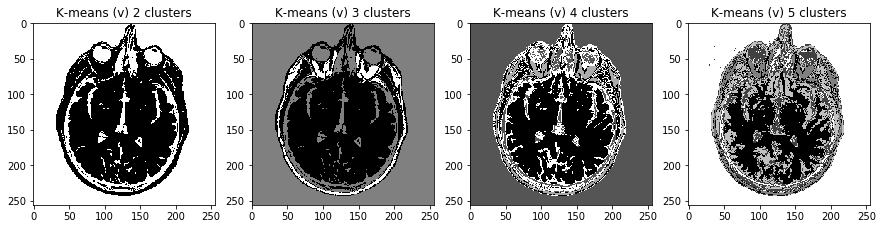

In [26]:
fig, ax = plt.subplots(1, len(brain_im_clustered), figsize=(15, 8))

for i in range(len(brain_im_clustered)):
    ax[i].imshow(brain_im_clustered[i], cmap='gray')
    ax[i].set_title(clustering_method_names[i])

As we can see K-means (v) with 4 clusters shows the best result.

In [27]:
_, counts = np.unique(brain_im_clustered[2], return_counts=True)
counts

array([19435, 35285,  2576,  8240], dtype=int64)

In [28]:
mask_kmeans = brain_im_clustered[2] == 0

regions = region_growing(mask_kmeans)
print(f"{len(regions)} shapes were found")

brain_region_coords = max(regions, key=len)

brain_mask_kmeans = np.full(brain_im.shape, fill_value=False)
for coords in brain_region_coords:
    brain_mask_kmeans[coords] = True

513 shapes were found


### 1.5 Now lets compare all results and calculate brain sizes

Method: Double Threshold + closing + median      brain's size: 15410 pixels
Method: 3 Gaussians                              brain's size: 237 pixels
Method: K-means (v) 4 clusters                   brain's size: 15376 pixels


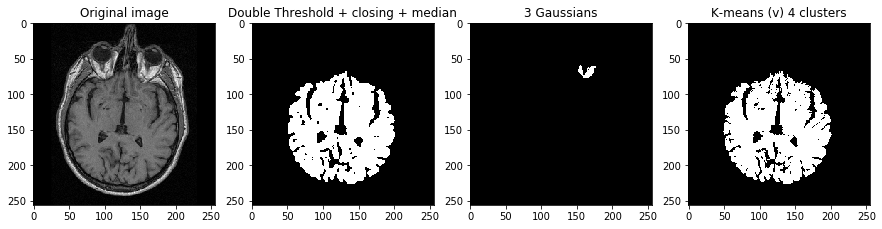

In [29]:
titles = ["Original image", "Double Threshold + closing + median", "3 Gaussians", "K-means (v) 4 clusters"]

images = [brain_im]
masks = [brain_mask_double_threshold_closing_median,
         brain_mask_gaussian,
         brain_mask_kmeans
         ]

images += masks

fig, ax = plt.subplots(1, len(images), figsize=(15, 10))

for i in range(len(masks)):
    print(f"Method: {titles[i + 1]:40s} brain's size: {np.count_nonzero(masks[i])} pixels")
        
for i in range(len(images)):
    ax[i].imshow(images[i], cmap='gray')
    ax[i].set_title(titles[i])

Since we developed several methods for calculating brain's size, let's use them as ensemble. Thus, resulting size will be average among all obtained ones.

In [30]:
brain_size = int(np.mean([np.count_nonzero(mask) for mask in masks]))

In [62]:
np.std([np.count_nonzero(mask) for mask in masks])

7144.620400459822

In [64]:
error = None # TODO: Estimate error

In [65]:
print(f"Brain's size is {brain_size} +- {error} pixels.")

Brain's size is 10341 +- None pixels.


## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [32]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


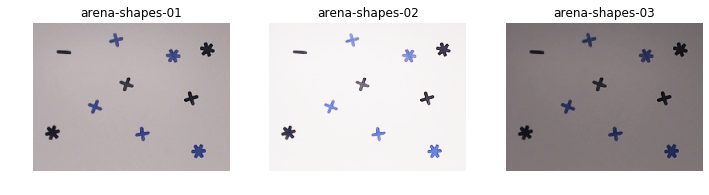

In [33]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color
Add your implementation and discussion

As first step we will try to distinguish foreground (shapes) from background. For that we will use contour based methods, namely Canny filter.

In [34]:
ind = 2 # Choose which image to process

In [35]:
image = images[ind]

In [36]:
grayscale = rgb2gray(image) * 255

In [37]:
edges = canny(grayscale/255.) # We will use popular Canny filter for edge detection

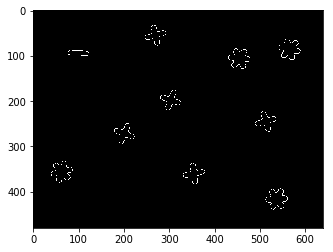

In [38]:
plt.imshow(edges, cmap="gray")
plt.show()

Great, now we have edges. Method worked relatively good even with default parameters. One reason for it is that source image has quite low level of noise.

Now we have to fill holes in shapes. For that we will use mathematical morphology methods. We will do closing with increasing size of structuring element till holes will be fully filled.

In [39]:
square_size = [5, 10, 20, 30, 40, 50]
mask_similarity_threshold = 0.999

shapes_mask = closing(edges, selem=square(square_size[0]))
for size in square_size[1:]:
    new_shapes_mask = closing(edges, selem=square(size))
    if np.sum(new_shapes_mask == shapes_mask) / shapes_mask.size > mask_similarity_threshold:
        break
    shapes_mask = new_shapes_mask

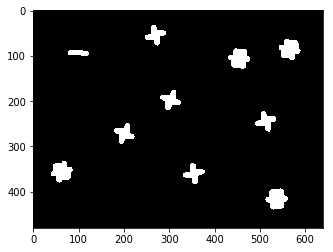

In [40]:
plt.imshow(shapes_mask, cmap="gray")
plt.show()

Now lets store pixels of each shape. For that we will use region growing method implemeneted in first part.

In [41]:
%time regions = region_growing(shapes_mask)
print(f"{len(regions)} shapes were found")

Wall time: 155 ms
10 shapes were found


Now we can use all pixels from region to calculate mean value

In [42]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.17824773, 60.11782477, 88.85498489],
       [36.35939553, 33.80617608, 39.32851511],
       [57.66644866, 59.76062786, 89.57030739],
       [39.12398374, 36.46341463, 41.17886179],
       [53.65575304, 50.03367633, 54.98409729],
       [37.33142857, 34.22666667, 38.15809524],
       [57.91713222, 60.19739292, 90.89199255],
       [36.91267236, 34.89954038, 40.01904137],
       [50.63235294, 53.1372549 , 86.69313725],
       [48.46991767, 52.96516783, 87.59784674]])

In [43]:
region_colors = np.zeros(shape=(len(regions), 3))

for ind, region in enumerate(regions):
    pixel_values = np.array([image[pixel] for pixel in region])
    region_colors[ind, :] = pixel_values.mean(axis=0)
    
region_colors

array([[58.17824773, 60.11782477, 88.85498489],
       [36.35939553, 33.80617608, 39.32851511],
       [57.66644866, 59.76062786, 89.57030739],
       [39.12398374, 36.46341463, 41.17886179],
       [53.65575304, 50.03367633, 54.98409729],
       [37.33142857, 34.22666667, 38.15809524],
       [57.91713222, 60.19739292, 90.89199255],
       [36.91267236, 34.89954038, 40.01904137],
       [50.63235294, 53.1372549 , 86.69313725],
       [48.46991767, 52.96516783, 87.59784674]])

We know that there are two colors: blue and gray. Gray color has relatively small std between color channels compared to blue color. Lets exploit that. 

In [44]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.02635825743628,
 2.256615680448259,
 14.571123582462397,
 1.9303595988580713,
 2.092064523508547,
 1.6924359457855558,
 15.03588097155406,
 2.105852139628952,
 16.440640497250843,
 17.482132325284848]

In [45]:
region_std = [np.std(color) for color in region_colors]
region_std

[14.02635825743628,
 2.256615680448259,
 14.571123582462397,
 1.9303595988580713,
 2.092064523508547,
 1.6924359457855558,
 15.03588097155406,
 2.105852139628952,
 16.440640497250843,
 17.482132325284848]

In the current task, when the number of shapes of blue and gray is balanced, we can use the value of the mean standard deviation as a threshold. However, this approach will work worse when the number of figures of the same color is poorly balanced. For example, in the case of 10 grays and only 1 blue shape, our method is likely to mark some gray colors (with the highest std value) as blue.

In [46]:
mean_std = np.mean(region_std)
mean_std

8.763346352221781

In [47]:
region_labels = ["Blue" if region_std[region_ind] > mean_std else "Gray" for region_ind in range(len(regions))]
region_labels

['Blue',
 'Gray',
 'Blue',
 'Gray',
 'Gray',
 'Gray',
 'Blue',
 'Gray',
 'Blue',
 'Blue']

In [48]:
print(f"Now we can say that we have {region_labels.count('Blue')} blue and {region_labels.count('Gray')} gray shapes.")

Now we can say that we have 5 blue and 5 gray shapes.


Now, let's check that we labeled shapes correctly:

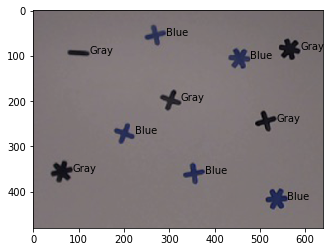

In [49]:
plt.imshow(image)
for ind in range(len(regions)):
    region_pixels = regions[ind]
    Y, X = zip(*region_pixels)
    plt.text(x=max(X), y = np.mean(Y), s=region_labels[ind])
plt.show()

Oui!

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

Our implementation of task 2.2 makes it easy to calculate total area of each color.

In [50]:
labels = ['Blue', "Gray"]
label_area = []

for label in labels:
    label_area.append(sum([len(regions[ind]) for ind in range(len(regions)) if region_labels[ind] == label]))
label_area

[6195, 5656]

In [51]:
print(f"There are {label_area[labels.index('Blue')]} blue and {label_area[labels.index('Gray')]} gray pixels.")

There are 6195 blue and 5656 gray pixels.
